# Project 4: Exploring the Seattle Airbnb Dataset 
# (Part 1 - Positive & Negative Reviews)

As part of the submission for the 4th Project in the Udacity Data Science Nanodegree, this notebook code from the analysis of the Seattle Airbnb dataset available on Kaggle: https://www.kaggle.com/airbnb/seattle/data.
Part 1 covers:

- Identifying positive and negative customer reviews/sentiment in the dataset 
- understanding customer sentiment and how it changed over time in different Seattle Neighbourhoods.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from langdetect import detect
from translate import Translator as tran
from googletrans import Translator
import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models import HdpModel
from gensim.parsing.preprocessing import preprocess_string
import nltk
import time
from afinn import Afinn
import seaborn as sns

In [3]:
#read in review data
reviews = pd.read_csv(r"C:\Users\Adetomiwa\Desktop\DATA SCIENCE DEGREE\Python\Project 4\seattle\reviews.csv")

In [4]:
reviews.shape

(84849, 6)

In [5]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [6]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null object
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


In [7]:
# We'll drop the blank comment columns
reviews = reviews.dropna()

In [8]:
# Detect the languages of each comment for anomalies
comments = pd.DataFrame(reviews['comments'])
language = []
lang_index = []
errors = []
for index, row in comments.iterrows():
    try:
        language += [detect(str(comments.comments[index]))]
        lang_index += [index]
    except: 
        language += ['investigate']
        lang_index += [index]
        errors.append(index)
        print('this index gives an error:',index)

this index gives an error: 4300
this index gives an error: 8863
this index gives an error: 9112
this index gives an error: 10303
this index gives an error: 13890
this index gives an error: 28801
this index gives an error: 35051
this index gives an error: 51426
this index gives an error: 66132
this index gives an error: 67811
this index gives an error: 71206
this index gives an error: 77823


In [9]:
# Create a dataframe of the language values maintaining the original index of where they came from
lang_df = pd.DataFrame({'language':language}, index = lang_index)

In [10]:
# add, language to the dataframe, check how many languges to translate/investigate
reviews['language'] = lang_df
reviews['language'].value_counts()

en             83785
fr               235
de               212
zh-cn            160
es                79
ko                52
ro                41
nl                38
ja                29
pt                26
it                24
af                23
zh-tw             22
so                15
da                13
investigate       12
sv                10
ru                 8
no                 8
ca                 6
fi                 5
pl                 5
tr                 3
cy                 2
vi                 2
sl                 2
tl                 2
cs                 2
hr                 2
sq                 1
el                 1
fa                 1
hu                 1
sk                 1
th                 1
sw                 1
et                 1
Name: language, dtype: int64

In [11]:
# Let's grab the reviews we want to investigate

reviews[reviews['language'] == 'investigate']

,listing_id,id,date,reviewer_id,reviewer_name,comments,language
4300,3953365,23777971,2014-12-09,20938014,Will,.,investigate
8863,7932696,46414097,2015-09-10,41768154,Tia,...,investigate
9112,2004931,38447903,2015-07-15,11978631,Hitesh,:),investigate
10303,1900698,20713118,2014-10-04,21526819,Chohye,-,investigate
13890,2274086,40490627,2015-07-31,29884964,Sarah,:),investigate
28801,4516960,30446205,2015-04-22,27856782,Kelly,*,investigate
35051,3706719,17646574,2014-08-15,9679616,Mika,.,investigate
51426,777159,13335174,2014-05-25,12937418,Maxime,.,investigate
66132,1048798,11382465,2014-03-31,13397363,Christine,..,investigate
67811,488268,12690425,2014-05-08,6192400,Jackie,.,investigate


- We see 2 comments with happy reviews and will keep these comments :) 
- Other comments we expect to drop off with further preprocessing and cleansing

In [12]:
# replace happy smileys with 'I am happy' and update their language to english
reviews.loc[reviews.comments == ":)", 'comments'] = '"I am happy"'
reviews.loc[(reviews.comments == '"I am happy"') & (reviews.language == 'investigate'), 'language'] = 'en'


In [13]:
# Drop other 'investigate' languages.
reviews = reviews[reviews.language != 'investigate']
reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments,language
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,en
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,en
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",en
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,en
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,en
...,...,...,...,...,...,...,...
84844,3624990,50436321,2015-10-12,37419458,Ryan,The description and pictures of the apartment ...,en
84845,3624990,51024875,2015-10-17,6933252,Linda,We had an excellent stay. It was clean and com...,en
84846,3624990,51511988,2015-10-20,19543701,Jaime,"Gran ubicación, cerca de todo lo atractivo del...",es
84847,3624990,52814482,2015-11-02,24445024,Jørgen,"Very good apartement, clean and well sized. Si...",en


In [14]:
# Tranlate function using Translate 

def translate_comments(df): 
    '''
    Translate the comments column of a dataframe
    df - dataframe containing comments
    result will append a column 'en_comments' which stores the english translation in the same dataframe
    '''
    translator = tran(to_lang = 'en')
    for idx, row in df.iterrows():
        if df.loc[idx, 'language'] != 'en':
            df.loc[idx, 'en_comments'] = translator.translate(row['comments'])
    return df

In [23]:
# Tranlate function using GoogleTrans 

def translate_comments_goog(df): 
    '''
    Translate the comments column of a dataframe
    df - dataframe containing comments
    result will append a column 'en_comments' which stores the english translation in the same dataframe
    '''
    
    for idx, row in df.iterrows():
        if df.loc[idx, 'language'] != 'en':
            source = df.loc[idx, 'language']
            translator = Translator()
            df.loc[idx, 'en_comments'] = translator.translate(row['comments'], src = source, dest = 'en').text
            time.sleep(2)

    return df

***Why are there 2 Translation functions?!***

I tested 2 different translation functions originally, as I was having trouble getting them to work. Ultimately got the google translate api working with a couple of tweaks: 

- Only passed a subset of non-english comments to be translated
- Added a sleep time of 1 second in between each iteration, given the google translate API limits within a certain time window. This added some processing time.


In [24]:
# Identify the reviews to translate to english

translate_me = reviews[reviews.language != 'en']
translate_me

,listing_id,id,date,reviewer_id,reviewer_name,comments,language
80,7735100,43837578,2015-08-22,40603512,Puhong,我们是一家三口，可爱的女儿，夫妻二人都是中国来的访问学者，来到美丽的西雅图，住在了Roger...,zh-cn
288,7550234,47535547,2015-09-20,40619236,Theo,Sehr gut,de
301,7550234,56949077,2015-12-20,47521443,Ying,房间的描述与实际相符，离华盛顿西雅图分校很近，非常完美，干净且安静，wifi很好，早餐也比较...,zh-cn
386,1205666,16974756,2014-08-05,14362449,Uwe,Sean und seine Frau Clara sind sehr freundlich...,de
404,1205666,19475353,2014-09-13,18033144,Petra,Es war wundervoll bei Sean und seiner Familie....,de
...,...,...,...,...,...,...,...
84121,6079131,46598039,2015-09-12,28649034,Martha Eugenia,"Fue agradable, los anfitriones preparan tu est...",es
84217,264829,28179087,2015-03-19,28485297,Gele,nice place it stadies like home,af
84338,7619060,52305251,2015-10-27,20806545,Kevin,非常舒适安静的房子，床边有窗户，晚上睡觉可以看见星星月亮，房东非常热情，退房的时候我去机场，...,zh-cn
84378,4577542,44747593,2015-08-29,25805389,Sebastian,"Die Unterkunft war sehr schön und genau so, wi...",de


In [25]:
# Translate non-english reviews

translated_reviews = translate_comments_goog(translate_me)

In [31]:
translated_reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,en_comments
80,7735100,43837578,2015-08-22,40603512,Puhong,我们是一家三口，可爱的女儿，夫妻二人都是中国来的访问学者，来到美丽的西雅图，住在了Roger...,zh-cn,"We are a family of three, lovely daughter, hus..."
288,7550234,47535547,2015-09-20,40619236,Theo,Sehr gut,de,Very good
301,7550234,56949077,2015-12-20,47521443,Ying,房间的描述与实际相符，离华盛顿西雅图分校很近，非常完美，干净且安静，wifi很好，早餐也比较...,zh-cn,Description consistent with the reality of the...
386,1205666,16974756,2014-08-05,14362449,Uwe,Sean und seine Frau Clara sind sehr freundlich...,de,"Sean and his wife Clara are very friendly, att..."
404,1205666,19475353,2014-09-13,18033144,Petra,Es war wundervoll bei Sean und seiner Familie....,de,It was wonderful when Sean and his family. The...
...,...,...,...,...,...,...,...,...
84121,6079131,46598039,2015-09-12,28649034,Martha Eugenia,"Fue agradable, los anfitriones preparan tu est...",es,"It was nice, the hosts prepare your stay with ..."
84217,264829,28179087,2015-03-19,28485297,Gele,nice place it stadies like home,af,nice place it stadies like home
84338,7619060,52305251,2015-10-27,20806545,Kevin,非常舒适安静的房子，床边有窗户，晚上睡觉可以看见星星月亮，房东非常热情，退房的时候我去机场，...,zh-cn,"Very comfortable and quiet house, bed windows,..."
84378,4577542,44747593,2015-08-29,25805389,Sebastian,"Die Unterkunft war sehr schön und genau so, wi...",de,The accommodation was very nice and exactly as...


In [32]:
# Obain the english comments and create an 'en_comments' column to match the translated dataframe
english_comments = reviews[reviews.language == 'en']
english_comments.loc[english_comments.index,'en_comments'] = english_comments.loc[english_comments.index, 'comments']

In [33]:
# Append newly translated reviews to the other reviews that were already english
reviews_en = english_comments.append(translated_reviews)

In [34]:
#Check for null/missing values
reviews_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84821 entries, 0 to 84846
Data columns (total 8 columns):
listing_id       84821 non-null int64
id               84821 non-null int64
date             84821 non-null object
reviewer_id      84821 non-null int64
reviewer_name    84821 non-null object
comments         84821 non-null object
language         84821 non-null object
en_comments      84821 non-null object
dtypes: int64(3), object(5)
memory usage: 5.8+ MB


In [35]:
# Gensim Preprocessing function, Removing accented characters, Removing Special Characters, Stemming, Removing Stopwords

def process_text(df):
    '''
    perform preprocessing steps on column of a df containing review text.
    
    df - The dataframe containing text
    result will be df will a new 'text' column appended with the output of the preprocessing
    
    '''
    df['text'] = df['en_comments'].apply(lambda x: preprocess_string(str(x)))
    
    return df

In [36]:
# Preprocessing text to prepare for lexicon scoring

process_text(reviews_en)

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,en_comments,text
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,en,Cute and cozy place. Perfect location to every...,"[cute, cozi, place, perfect, locat]"
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,en,Kelly has a great room in a very central locat...,"[kelli, great, room, central, locat, beauti, b..."
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",en,"Very spacious apartment, and in a great neighb...","[spaciou, apart, great, neighborhood, kind, ap..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,en,Close to Seattle Center and all it has to offe...,"[close, seattl, center, offer, ballet, theater..."
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,en,Kelly was a great host and very accommodating ...,"[kelli, great, host, accommod, great, neighbor..."
...,...,...,...,...,...,...,...,...,...
84121,6079131,46598039,2015-09-12,28649034,Martha Eugenia,"Fue agradable, los anfitriones preparan tu est...",es,"It was nice, the hosts prepare your stay with ...","[nice, host, prepar, stai, detail, purpos, tri..."
84217,264829,28179087,2015-03-19,28485297,Gele,nice place it stadies like home,af,nice place it stadies like home,"[nice, place, stadi, like, home]"
84338,7619060,52305251,2015-10-27,20806545,Kevin,非常舒适安静的房子，床边有窗户，晚上睡觉可以看见星星月亮，房东非常热情，退房的时候我去机场，...,zh-cn,"Very comfortable and quiet house, bed windows,...","[comfort, quiet, hous, bed, window, moon, star..."
84378,4577542,44747593,2015-08-29,25805389,Sebastian,"Die Unterkunft war sehr schön und genau so, wi...",de,The accommodation was very nice and exactly as...,"[accommod, nice, exactli, describ, photo, apar..."


In [37]:
# Convert text list to string for afinn scoring
reviews_en['text'] = [' '.join(map(str, l)) for l in reviews_en['text']]

In [38]:
reviews_en.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,en_comments,text
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,en,Cute and cozy place. Perfect location to every...,cute cozi place perfect locat
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,en,Kelly has a great room in a very central locat...,kelli great room central locat beauti build ar...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",en,"Very spacious apartment, and in a great neighb...",spaciou apart great neighborhood kind apart wi...
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,en,Close to Seattle Center and all it has to offe...,close seattl center offer ballet theater museu...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,en,Kelly was a great host and very accommodating ...,kelli great host accommod great neighborhood g...


In [39]:
# Score Sentiment with Afinn
af = Afinn()

# compute sentiment scores (polarity) and labels
reviews_en['sentiment'] = [af.score(text) for text in reviews_en.text]


In [40]:
reviews_en[reviews_en['sentiment']<0].sort_values('sentiment')

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,en_comments,text,sentiment
67499,3528627,35373295,2015-06-18,29877821,Jun-Yan,"If you want to get disturbed everyday, have no...",en,"If you want to get disturbed everyday, have no...",want disturb everydai privaci insult bother mo...,-14.0
32261,719233,43363616,2015-08-19,16539984,Rebecca,A disappointment. The initial information did ...,en,A disappointment. The initial information did ...,disappoint initi inform disclos mold mildew pr...,-12.0
71158,3449059,32507141,2015-05-19,29317777,Jane,"While the location of this place is great, we ...",en,"While the location of this place is great, we ...",locat place great lot difficulti hostess don’t...,-11.0
52607,1815472,11178798,2014-03-24,12007893,Matt,This is a lovely space. Unfortunately it's ab...,en,This is a lovely space. Unfortunately it's ab...,love space unfortun bar close fridai saturdai ...,-10.0
71767,4668327,38610829,2015-07-17,10124037,Brittany,We were very disappointed in our stay with Bri...,en,We were very disappointed in our stay with Bri...,disappoint stai bri hous unclean unswept floor...,-10.0
...,...,...,...,...,...,...,...,...,...,...
30987,353347,20272312,2014-09-26,17599355,Robert,The reservation was canceled 26 days before ar...,en,The reservation was canceled 26 days before ar...,reserv cancel dai arriv autom post,-1.0
30929,7800238,53034280,2015-11-03,24011318,Elie,"This was a fantastic place! Very cozy, cute pr...",en,"This was a fantastic place! Very cozy, cute pr...",fantast place cozi cute propan stove happi sta...,-1.0
30921,5744931,35362144,2015-06-17,13584908,Peggy,The host canceled this reservation 41 days bef...,en,The host canceled this reservation 41 days bef...,host cancel reserv dai arriv autom post,-1.0
28408,4814894,35628167,2015-06-20,4586273,Stephen,The host canceled this reservation 22 days bef...,en,The host canceled this reservation 22 days bef...,host cancel reserv dai arriv autom post,-1.0


In [41]:
#Import listings dataset to merge descriptive columns for the listings (location, neighbourhood.. etc)
listings = pd.read_csv(r"C:\Users\Adetomiwa\Desktop\DATA SCIENCE DEGREE\Python\Project 4\seattle\listings.csv")

In [42]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [43]:
# Choose the columns from the listing dataset to be joined to the reviews data
add_cols = listings[['street','neighbourhood_cleansed','latitude', 'longitude', 'property_type']]

#merge columns to create a new dataframe
reviews_final = pd.merge(reviews_en, add_cols, 
         left_on = reviews_en['listing_id'], 
         right_on = listings['id'], 
         how='left').drop(['key_0','id','reviewer_id','reviewer_name','comments'], axis =1)

In [44]:
reviews_final.head()

,listing_id,date,language,en_comments,text,sentiment,street,neighbourhood_cleansed,latitude,longitude,property_type
0,7202016,2015-07-19,en,Cute and cozy place. Perfect location to every...,cute cozi place perfect locat,5.0,"3rd Avenue West, Seattle, WA 98119, United States",Lower Queen Anne,47.62621,-122.360147,Apartment
1,7202016,2015-07-20,en,Kelly has a great room in a very central locat...,kelli great room central locat beauti build ar...,17.0,"3rd Avenue West, Seattle, WA 98119, United States",Lower Queen Anne,47.62621,-122.360147,Apartment
2,7202016,2015-07-26,en,"Very spacious apartment, and in a great neighb...",spaciou apart great neighborhood kind apart wi...,6.0,"3rd Avenue West, Seattle, WA 98119, United States",Lower Queen Anne,47.62621,-122.360147,Apartment
3,7202016,2015-08-02,en,Close to Seattle Center and all it has to offe...,close seattl center offer ballet theater museu...,1.0,"3rd Avenue West, Seattle, WA 98119, United States",Lower Queen Anne,47.62621,-122.360147,Apartment
4,7202016,2015-08-10,en,Kelly was a great host and very accommodating ...,kelli great host accommod great neighborhood g...,18.0,"3rd Avenue West, Seattle, WA 98119, United States",Lower Queen Anne,47.62621,-122.360147,Apartment


In [45]:
# Check to ensure no blank values
reviews_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84821 entries, 0 to 84820
Data columns (total 11 columns):
listing_id                84821 non-null int64
date                      84821 non-null object
language                  84821 non-null object
en_comments               84821 non-null object
text                      84821 non-null object
sentiment                 84821 non-null float64
street                    84821 non-null object
neighbourhood_cleansed    84821 non-null object
latitude                  84821 non-null float64
longitude                 84821 non-null float64
property_type             84821 non-null object
dtypes: float64(3), int64(1), object(7)
memory usage: 7.8+ MB


In [46]:
#Save processed data into a csv file
reviews_final.to_csv("reviews_final.csv")

In [47]:
# Add column for Sentiment verdict
reviews_final['verdict'] = ['positive' if x >0
                               else 'negative' if x < 0
                                   else 'neutral'
                                       for x in reviews_final.sentiment]

In [48]:
verdicts =  pd.DataFrame(reviews_final.verdict.value_counts())

In [49]:
verdicts['proportion'] = round(100*verdicts['verdict']/verdicts['verdict'].sum(),1)

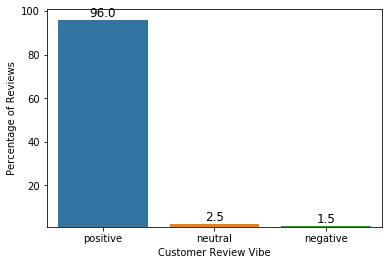

In [51]:
#  Plot proportion of Reviews
ax = sns.barplot(x=verdicts.index, y="proportion", data=verdicts)
plt.xlabel('Customer Review Vibe')
plt.ylabel('Percentage of Reviews')
ax = plt.gca()
y_max = 100 
ax.set_ylim(1)
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.1f}'.format(p.get_height()), 
        fontsize=12, ha='center', va='bottom')

# Project 4: Exploring the Seattle Airbnb Dataset 
# (Part 2 - Neighbourhood Vibe)

Part 2 of the project dives into trying to understand the vibe of some of the top neighbourhoods through topic modelling. 


In [52]:
# Read in Listings
listings = pd.read_csv(r"C:\Users\Adetomiwa\Desktop\DATA SCIENCE DEGREE\Python\Project 4\seattle\listings.csv")

In [53]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

In [54]:
# we'll select the cleansed neighbouhoods and neighbouhood overview columns 
subset = ["neighbourhood_cleansed","neighborhood_overview"]
listings_new = listings[subset]

In [55]:
listings_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 2 columns):
neighbourhood_cleansed    3818 non-null object
neighborhood_overview     2786 non-null object
dtypes: object(2)
memory usage: 59.8+ KB


In [56]:
# Filter out the null values
listings_new = listings_new[listings_new['neighborhood_overview'].notnull()]

In [57]:
# A glance at value counts for each neighbourhood
listings_new['neighbourhood_cleansed'].value_counts()

Broadway             266
Belltown             146
Wallingford          146
Fremont              122
Minor                108
                    ... 
Arbor Heights          4
South Beacon Hill      3
Holly Park             3
Roxhill                2
South Park             1
Name: neighbourhood_cleansed, Length: 87, dtype: int64

**NOTES**

We'll be viewing topics in 3 of the top neighbourhoods

- Broadway
- Belltown
- Wallingford

In [58]:
broadway = listings_new.loc[listings_new['neighbourhood_cleansed'] == 'Broadway']

In [59]:
broadway = broadway.drop('neighbourhood_cleansed', axis =1)

In [60]:
exclude = ['capitol','hill', 'seattle', 'neighbourhood', 'neighborhood','walk','walking']
broadway["neighborhood_overview"] = broadway["neighborhood_overview"].str.lower().str.split().apply(lambda x: [item for item in x if item not in exclude])

In [61]:
broadway

,neighborhood_overview
2577,"[this, location, sits, in, the, middle, betwee..."
2579,"[the, flat, is, smack, dab, in, the, middle, o..."
2582,"[we, love, everything, about, this, (url, hidd..."
2584,"[is, fun, for, any, age,, there, are, many, ac..."
2586,"[is, one, of, the, fastest, growing,, eclectic..."
...,...
2964,"[situated, on, the, eastern, bench, of, downto..."
2966,"[is, the, best, of, both, worlds--quiet, resid..."
2968,"[i, live, right, on, 15th, avenue, where, ther..."
2969,"[is, one, of, the, best, neighborhoods!, it, i..."


In [62]:
broadway.to_csv("broadway.csv")

In [63]:
#Save belltown overviews to csv

belltown = listings_new.loc[listings_new['neighbourhood_cleansed'] == 'Belltown']
belltown = belltown.drop('neighbourhood_cleansed', axis =1)
belltown["neighborhood_overview"] = belltown["neighborhood_overview"].str.lower().str.split().apply(lambda x: [item for item in x if item not in exclude])
belltown.to_csv("belltown.csv")

In [64]:
#Save wallingford overviews to csv

wallingford = listings_new.loc[listings_new['neighbourhood_cleansed'] == 'Wallingford']
wallingford = wallingford.drop('neighbourhood_cleansed', axis =1)
wallingford["neighborhood_overview"] = wallingford["neighborhood_overview"].str.lower().str.split().apply(lambda x: [item for item in x if item not in exclude])
wallingford.to_csv("Wallingford.csv")

# NOTE: 

- Attempted a topic modelling model for the neighborhood overviews to see if any distinct topics would emerge different from word frequencies in a word cloud. Results were similar in the observed model but decided to proceed with a word cloud visualization in Power BI as seen in the Blog Post